In [22]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pickle as pkl

import seaborn as sns
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device = {device}")

device = cuda:0


In [3]:
from Example import generate_charge_arrangement, make_S_all_steps

[[-0.77103926 -0.58911206 -0.24175492]
 [ 0.27038991 -0.64660657  0.71329464]
 [-0.57653079  0.48461008  0.65784901]]


In [4]:
# Parameters
N_train = 100
N_test = 100
n = 4
batch_size = 1
num_workers = 4

# Parameter
hidden_size = 10
output_size = 9
input_size = 3 * (2 * n + 1)
learning_rate = 0.001
num_epochs = 1000

# Generating the training data:
source_positions, source_velocities, source_charges, target_positions = generate_charge_arrangement(N_train, n)
S = make_S_all_steps(source_positions, source_charges, source_velocities, target_positions)

train_source_positions = np.stack([source_positions for _ in range(N_train)])
train_source_velocities = np.stack([source_velocities for _ in range(N_train)])
train_source_charges = np.stack([source_charges for _ in range(N_train)])
train_target_positions = target_positions.reshape(N_train, 1, 3)

traindata = np.concatenate([train_source_positions, train_source_velocities, train_target_positions], axis = 1)
trainvalues = S

traindata = torch.Tensor(traindata)
trainvalues = torch.Tensor(trainvalues)

# Generating the training data:
source_positions, source_velocities, source_charges, target_positions = generate_charge_arrangement(N_test, n)
S = make_S_all_steps(source_positions, source_charges, source_velocities, target_positions)

test_source_positions = np.stack([source_positions for _ in range(N_test)])
test_source_velocities = np.stack([source_velocities for _ in range(N_test)])
test_source_charges = np.stack([source_charges for _ in range(N_test)])
test_target_positions = target_positions.reshape(N_test, 1, 3)

testdata = np.concatenate([test_source_positions, test_source_velocities, test_target_positions], axis = 1)
testvalues = S

testdata = torch.Tensor(testdata)
testvalues = torch.Tensor(testvalues)

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, values):
        self.data = data
        self.values = values
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.values[idx]
    
trainset = MyDataset(traindata,trainvalues)#
#testset = MyDataset(testdata,test)
    
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
#testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=num_workers,pin_memory=True)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

class MyNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = x.reshape(batch_size, -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


net = MyNet(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Training loop
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    for i, (inputs, values) in enumerate(trainloader, 0):
        inputs = inputs.to(device)
        values = values.to(device)
          
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, values.reshape(batch_size, -1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # print(f'Epoch {epoch+1}, Loss: {running_loss / (i+1)}')

print('Finished Training')
print(f'Final loss : {loss.item()}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Finished Training
Final loss : 0.7756795287132263


In [7]:
output_size = 81

In [18]:
class MyNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        s = torch.bmm(x, x.transpose(1,2))
        s = s.reshape(batch_size, -1)
        s = self.fc1(s)
        s = self.relu(s)
        s = self.fc2(s)
        s = s.reshape(batch_size, 9, 9, 1, 1)
        outer =  x[:, :, None, :, None] * x[:, None, :, None, :]
        out = torch.sum(s*outer,axis=(1,2))
        out = out.reshape(batch_size,-1) 
        return out
    

input_size = (2 * n + 1) ** 2
net = MyNet(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Training loop
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    for i, (inputs, values) in enumerate(trainloader, 0):
        inputs = inputs.to(device)
        values = values.to(device)
        values = values.reshape(batch_size, -1)
          
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, values)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # print(f'Epoch {epoch+1}, Loss: {running_loss / (i+1)}')

print('Finished Training')
print(f'Final loss : {loss.item()}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Finished Training
Final loss : 0.2741965651512146


In [19]:
# not sure what this mean, both the losses are big...
# maybe having 100 hidden size is just too much...

# Yeah, I think so too. It could be 

In [20]:
net

MyNet(
  (fc1): Linear(in_features=81, out_features=10, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=10, out_features=81, bias=True)
)

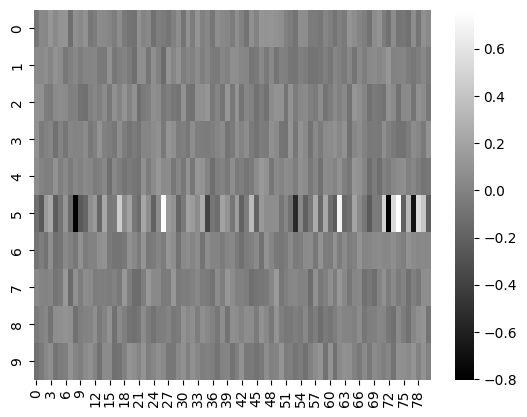

In [23]:
# Get the weights of fc1
weights = net.fc1.weight.data

# Plot the weights as an image
sns.heatmap(weights.cpu().numpy(), cmap='gray')
plt.show()